## Experiment 5.
##### This experiment compares various pre-trained models to see how they perform to KyleNet
##### The pre-trained models used are:
- VGG-19
- ResNet50
- Xception
- DenseNet121
- InceptionV3

In [81]:
import tensorflow as tf
from tensorflow.python.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.python.keras.models import Model, load_model
from KyleNet import KyleNet
from pathlib import Path
from tensorflow.keras.applications import VGG19, ResNet50, Xception, DenseNet121, InceptionV3
from tensorflow.keras.optimizers import Adam
import numpy as np

# Get the metadata
META = Path(".").resolve().parent.joinpath("metadata.csv")
import matplotlib.pyplot as plt

In [3]:
if tf.test.gpu_device_name():
    print(f"GPU Device: {tf.test.gpu_device_name()}\n")
else:
    print("Running off of CPU\n")

GPU Device: /device:GPU:0



##### Loops through all the pre-trained models to fetch the results

In [4]:
models = {}

for model in [VGG19, ResNet50, Xception, DenseNet121, InceptionV3]:
    print(f"\nTraining Model: {model.__name__}")

    # Configure the pre-trained model and make the input layers untrainable
    base_model = model(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # FC layers from KyleNet
    output = Flatten()(base_model.output)
    output = Dense(32, activation="relu")(output)
    output = BatchNormalization()(output)
    output = Dense(1, activation="sigmoid")(output)

    base_model = Model(base_model.input, output)
    base_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

    # KyleNet CNN gets swapped out on each loop
    exp5 = KyleNet(META,
                   f"Experiment 5 - {model.__name__}",
                   epochs=6,
                   balance_dataset=True)
    exp5.model = base_model

    # Save and train the model
    exp5.Train()
    exp5.Evaluate()
    exp5.Predict()
    exp5.Save()

    models[model.__name__] = exp5


Training Model: VGG19
Found 57830 validated image filenames belonging to 2 classes.
Found 19276 validated image filenames belonging to 2 classes.
Epoch 1/6
451/451 [==============================] - 394s 874ms/step - loss: 0.0834 - accuracy: 0.9762 - val_loss: 0.0462 - val_accuracy: 0.9905

In [ ]:
# Mock instance, only used to access the methods that show model performance
test = KyleNet(META, "")

##### View the classification report of each model

In [11]:
models

{'VGG19': <KyleNet.KyleNet at 0x1d99c9b5100>,
 'ResNet50': <KyleNet.KyleNet at 0x1db0a4a86d0>,
 'Xception': <KyleNet.KyleNet at 0x1db59083c40>,
 'DenseNet121': <KyleNet.KyleNet at 0x1db685a8df0>,
 'InceptionV3': <KyleNet.KyleNet at 0x1db7ebc4a90>}

In [20]:
for model in models:
    print(f"{'-'*50}\nReport for {model}\n")
    models[model].MetricReport()

--------------------------------------------------
Report for VGG19

              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00      9654
   NON-COVID       1.00      1.00      1.00      9622

    accuracy                           1.00     19276
   macro avg       1.00      1.00      1.00     19276
weighted avg       1.00      1.00      1.00     19276

--------------------------------------------------
Report for ResNet50

              precision    recall  f1-score   support

    COVID-19       0.98      0.99      0.99      9731
   NON-COVID       0.99      0.98      0.99      9545

    accuracy                           0.99     19276
   macro avg       0.99      0.99      0.99     19276
weighted avg       0.99      0.99      0.99     19276

--------------------------------------------------
Report for Xception

              precision    recall  f1-score   support

    COVID-19       0.99      0.99      0.99      9668
   NON-COVID       0.99 

##### View the acc/loss graphs of each model

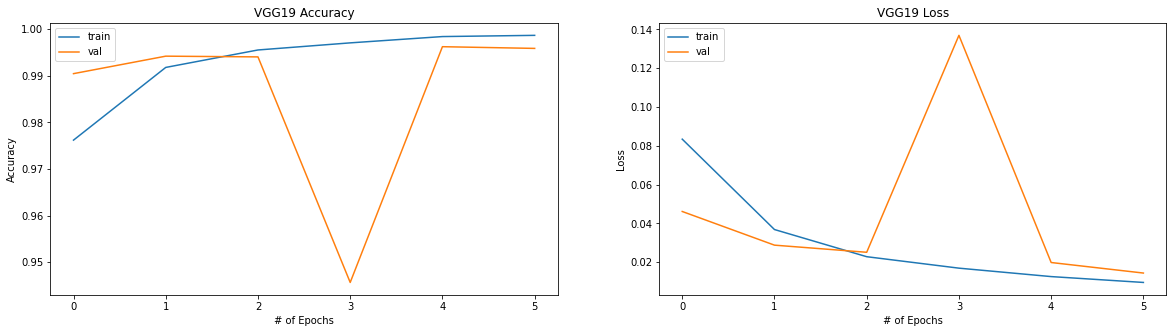

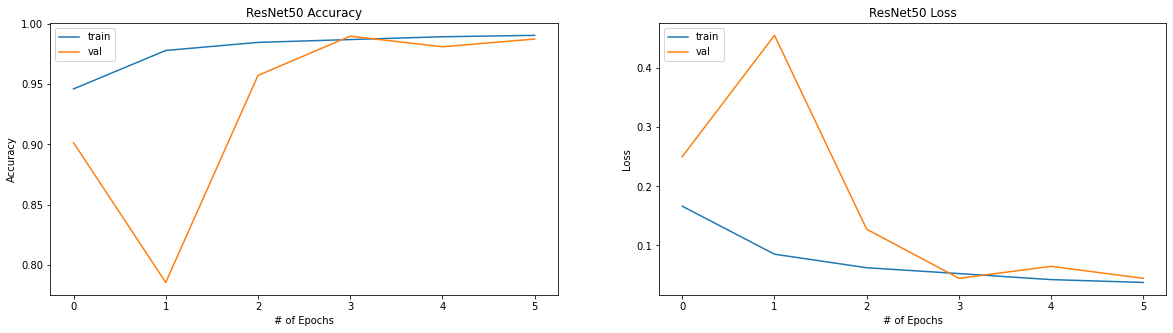

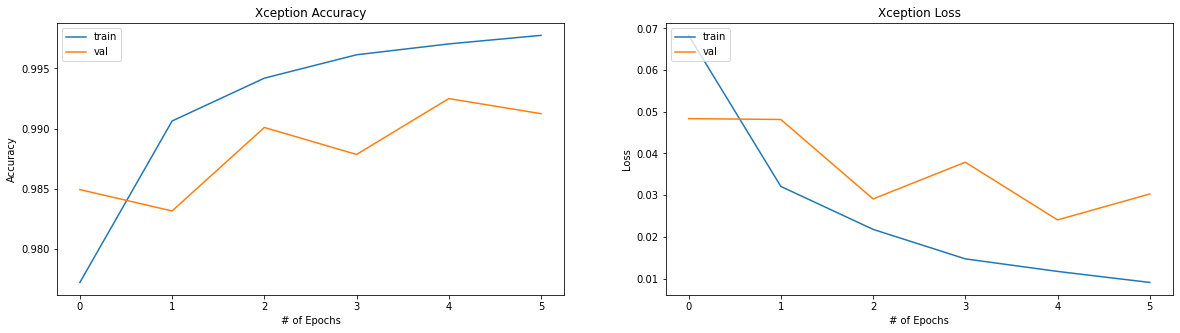

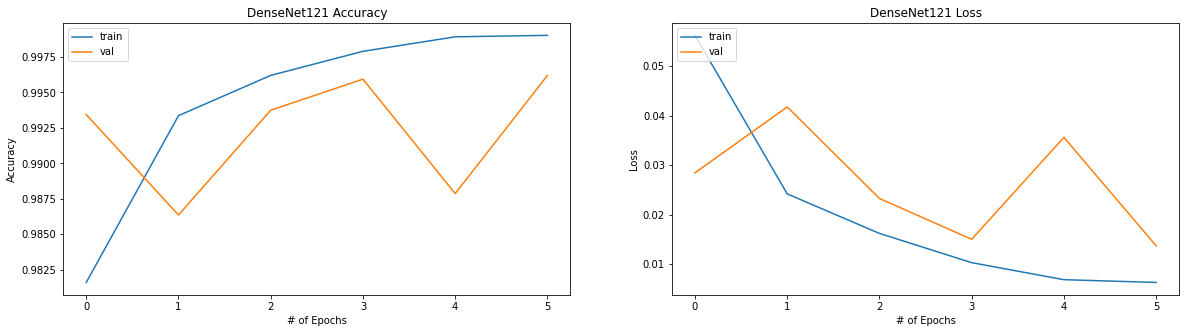

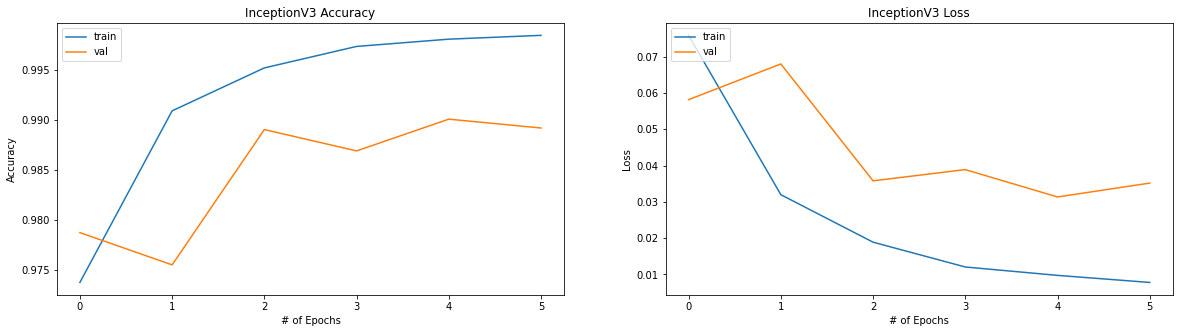

In [27]:
for model in models:
    models[model].PlotHistory(acc_title = f"{model} Accuracy",
                              loss_title = f"{model} Loss")

##### View the ROC curve of each model

Row 1 - VGG19
Row 2 - ResNet50
Row 3 - Xception
Row 4 - DenseNet121
Row 5 - InceptionV3


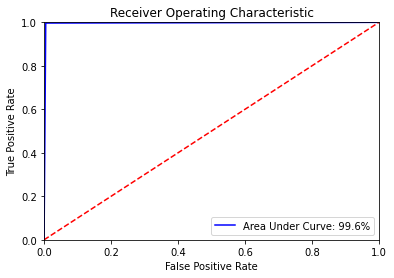

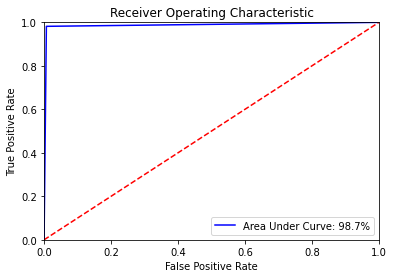

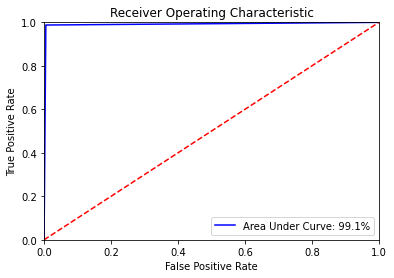

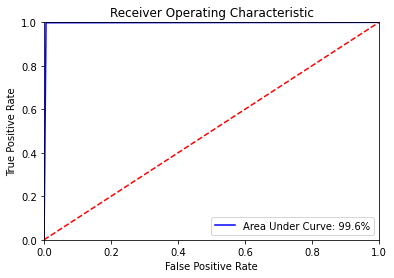

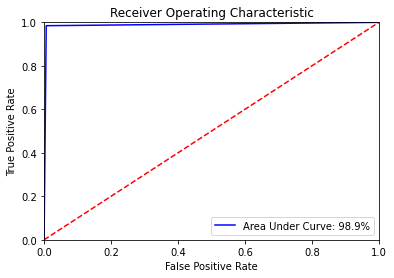

In [33]:
for index, model in enumerate(models):
    print(f"Row {index + 1} - {model}")
    models[model].ROC()

##### Compare the accuracies of each pre-trained model against KyleNet

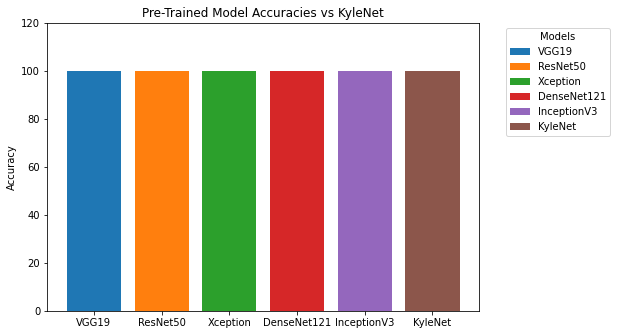

In [131]:
def random_color():
    rgb = tuple(np.random.random(size=3) * 256)

accuracies = [models[model].history.history["val_accuracy"][-1] for model in models] + [99.94]
modelNames = [model for model in models] + ["KyleNet"]

fig = plt.figure()
ax = fig.add_axes([1]*4)
ax.set_ylim(0,120)
ax.set_title("Pre-Trained Model Accuracies vs KyleNet")
ax.set_ylabel('Accuracy')

for model in modelNames:
    ax.bar(model, accuracies, color=random_color())

ax.legend(labels=modelNames, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()